In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

## Data imports

In [ ]:
# read data for chicken farm
data_for_model = pd.read_csv(r'C:\Users\Shivm\Documents\Masters\Research Project\Eskom air quality data\Eskom Model\PM10 Models\Combined Station Data.csv')
data_for_model['NO1'] = data_for_model['NO1'].fillna(data_for_model['NOX'] - data_for_model['NO2'])
#data_for_model.drop(columns=['anomaly'], inplace=True)
data_for_model

,Date,Wind,Wind Dir,SO2,NO2,NOX,PM10,wind_x,wind_y,PM2.5,Pressure,Temp,NO1,Date Time,Hour,Month,DayOfWeek,Wind_lag1,Wind Dir_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,wind_x_lag1,wind_y_lag1,PM2.5_lag1,Pressure_lag1,Temp_lag1,NO1_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,Wind Dir_roll3_mean,Wind Dir_roll3_std,Wind Dir_roll6_mean,Wind Dir_roll6_std,Wind Dir_roll12_mean,Wind Dir_roll12_std,Wind Dir_roll24_mean,Wind Dir_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,wind_x_roll3_mean,wind_x_roll3_std,wind_x_roll6_mean,wind_x_roll6_std,wind_x_roll12_mean,wind_x_roll12_std,wind_x_roll24_mean,wind_x_roll24_std,wind_y_roll3_mean,wind_y_roll3_std,wind_y_roll6_mean,wind_y_roll6_std,wind_y_roll12_mean,wind_y_roll12_std,wind_y_roll24_mean,wind_y_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Temp_roll3_mean,Temp_roll3_std,Temp_roll6_mean,Temp_roll6_std,Temp_roll12_mean,Temp_roll12_std,Temp_roll24_mean,Temp_roll24_std,NO1_roll3_mean,NO1_roll3_std,NO1_roll6_mean,NO1_roll6_std,NO1_roll12_mean,NO1_roll12_std,NO1_roll24_mean,NO1_roll24_std,Location_Camden,Location_Chicken Farm,Location_Grootvlei,Location_Komati,Location_Marapong,Location_Medupi,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend
0,2005/01/01 00:00:00,3.800000,80.5000,1.030,2.02,2.08,36.90,3.747885,0.627181,NaN,NaN,18.40,0.047,2005-01-01 00:00:00,0.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.800000,NaN,3.800000,NaN,3.800000,NaN,3.800000,NaN,80.500000,NaN,80.500000,NaN,80.500000,NaN,80.500000,NaN,1.030000,NaN,1.030000,NaN,1.030000,NaN,1.030000,NaN,2.020000,NaN,2.020000,NaN,2.020000,NaN,2.020000,NaN,2.080000,NaN,2.080000,NaN,2.080000,NaN,2.080000,NaN,36.900000,NaN,36.900000,NaN,36.900000,NaN,36.900000,NaN,3.747885,NaN,3.747885,NaN,3.747885,NaN,3.747885,NaN,0.627181,NaN,0.627181,NaN,0.627181,NaN,0.627181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.400000,NaN,18.400000,NaN,18.400000,NaN,18.400000,NaN,0.047000,NaN,0.047000,NaN,0.047000,NaN,0.047000,NaN,True,False,False,False,False,False,False,False,False,True,False,False,True
1,2005/01/01 01:00:00,3.920000,85.3000,1.090,1.65,1.68,25.50,3.906819,0.321199,NaN,NaN,18.60,0.045,2005-01-01 01:00:00,1.0,1.0,5.0,3.800000,80.5000,1.030,2.02,2.08,36.90,3.747885,0.627181,NaN,NaN,18.40,0.047,3.860000,0.084853,3.860000,0.084853,3.860000,0.084853,3.860000,0.084853,82.900000,3.394113,82.900000,3.394113,82.900000,3.394113,82.900000,3.394113,1.060000,0.042426,1.060000,0.042426,1.060000,0.042426,1.060000,0.042426,1.835000,0.261630,1.835000,0.261630,1.835000,0.261630,1.835000,0.261630,1.880000,0.282843,1.880000,0.282843,1.880000,0.282843,1.880000,0.282843,31.200000,8.061017,31.200000,8.061017,31.200000,8.061017,31.200000,8.061017,3.827352,0.112383,3.827352,0.112383,3.827352,0.112383,3.827352,0.112383,0.474190,0.216362,0.474190,0.216362,0.474190,0.216362,0.474190,0.216362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.500000,0.141421,18.500000,0.141421,18.500000,0.141421,18.500000,0.141421,0.046000,0.001414,0.046000,0.001414,0.046000,0.001414,0.046000,0.001414,True,False,False,False,False,False,False,False,False,True,False,False,True
2,2005/01/01 02:00

In [3]:
#null checks
data_for_model.isna().sum()

Date                   7
Wind               13120
Wind Dir           14117
SO2                66861
NO2                73089
                   ...  
Season_Spring          0
Season_Summer          0
Season_Winter          0
DayType_Weekday        0
DayType_Weekend        0
Length: 138, dtype: int64

In [4]:
data_for_model.dtypes

Date                object
Wind               float64
Wind Dir           float64
SO2                float64
NO2                float64
                    ...   
Season_Spring         bool
Season_Summer         bool
Season_Winter         bool
DayType_Weekday       bool
DayType_Weekend       bool
Length: 138, dtype: object

In [5]:
data_for_model['Year'] = pd.to_datetime(data_for_model['Date'],format="mixed").dt.year
data_for_model.drop(columns=['Date', 'Date Time'], inplace=True)


In [6]:
data_for_model.columns

Index(['Wind', 'Wind Dir', 'SO2', 'NO2', 'NOX', 'PM10', 'wind_x', 'wind_y',
       'PM2.5', 'Pressure',
       ...
       'Location_Marapong', 'Location_Medupi', 'Location_Phola',
       'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
       'DayType_Weekday', 'DayType_Weekend', 'Year'],
      dtype='object', length=137)

## Create Target variable and rolling features

In [ ]:
data_for_model['PM2.5_lag1'] = data_for_model['PM2.5'].shift(1)
data_for_model['PM2.5_lag2'] = data_for_model['PM2.5'].shift(2)
data_for_model['PM2.5_lag3'] = data_for_model['PM2.5'].shift(3)
#data_for_model['PM2.5_t+1'] = data_for_model['PM2.5'].shift(-1)
data_for_model['PM2.5_t+24'] = data_for_model['PM2.5'].shift(-24)
#data_for_model['PM2.5_t+6'] = data_for_model['PM2.5'].shift(-6)
#data_for_model['PM2.5_t+12'] = data_for_model['PM2.5'].shift(-12)


# Rolling means with different windows, shifted by 1 to prevent leakage
# data_for_model['PM2.5_roll3_mean'] = data_for_model['PM2.5'].rolling(window=3).mean().shift(1)
# data_for_model['PM2.5_roll6_mean'] = data_for_model['PM2.5'].rolling(window=6).mean().shift(1)
# data_for_model['PM2.5_roll12_mean'] = data_for_model['PM2.5'].rolling(window=12).mean().shift(1)
# data_for_model['PM2.5_roll24_mean'] = data_for_model['PM2.5'].rolling(window=24).mean().shift(1)
# data_for_model['PM2.5_roll3_std'] = data_for_model['PM2.5'].rolling(3).std().shift(1)
# data_for_model['PM2.5_roll6_std'] = data_for_model['PM2.5'].rolling(6).std().shift(1)
# data_for_model['PM2.5_roll12_std'] = data_for_model['PM2.5'].rolling(12).std().shift(1)
# data_for_model['PM2.5_roll24_std'] = data_for_model['PM2.5'].rolling(24).std().shift(1)
data_for_model['PM2.5_diff1'] = data_for_model['PM2.5'] - data_for_model['PM2.5'].shift(1)
data_for_model['Temp_diff1'] = data_for_model['Temp'] - data_for_model['Temp'].shift(1)


data_for_model = data_for_model.dropna().reset_index(drop=True)
# # # Split by year
df_train = data_for_model[(data_for_model['Year'] >= 2005) & (data_for_model['Year'] <= 2016)]
df_test = data_for_model[data_for_model['Year'] == 2017]
df_val = data_for_model[data_for_model['Year'] == 2018]


In [8]:
data_for_model

,Wind,Wind Dir,SO2,NO2,NOX,PM10,wind_x,wind_y,PM2.5,Pressure,Temp,NO1,Hour,Month,DayOfWeek,Wind_lag1,Wind Dir_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,wind_x_lag1,wind_y_lag1,PM2.5_lag1,Pressure_lag1,Temp_lag1,NO1_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,Wind Dir_roll3_mean,Wind Dir_roll3_std,Wind Dir_roll6_mean,Wind Dir_roll6_std,Wind Dir_roll12_mean,Wind Dir_roll12_std,Wind Dir_roll24_mean,Wind Dir_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,wind_x_roll3_mean,wind_x_roll3_std,wind_x_roll6_mean,wind_x_roll6_std,wind_x_roll12_mean,wind_x_roll12_std,wind_x_roll24_mean,wind_x_roll24_std,wind_y_roll3_mean,wind_y_roll3_std,wind_y_roll6_mean,wind_y_roll6_std,wind_y_roll12_mean,wind_y_roll12_std,wind_y_roll24_mean,wind_y_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Temp_roll3_mean,Temp_roll3_std,Temp_roll6_mean,Temp_roll6_std,Temp_roll12_mean,Temp_roll12_std,Temp_roll24_mean,Temp_roll24_std,NO1_roll3_mean,NO1_roll3_std,NO1_roll6_mean,NO1_roll6_std,NO1_roll12_mean,NO1_roll12_std,NO1_roll24_mean,NO1_roll24_std,Location_Camden,Location_Chicken Farm,Location_Grootvlei,Location_Komati,Location_Marapong,Location_Medupi,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend,Year,PM2.5_lag2,PM2.5_lag3,PM2.5_t+3,PM2.5_diff1,Temp_diff1
0,7.156286,91.864860,13.810,1.324,10.920,146.10,7.152496,-0.232881,53.25,844.0,22.32,14.190,16.0,1.0,4.0,6.538234,94.814120,17.240,1.212,12.660,141.30,6.515168,-0.548711,51.60,843.0,22.84,15.760,6.545746,0.606818,6.248888,0.521865,5.386216,1.413779,3.545463,2.143104,96.116160,5.030330,100.225297,5.786552,88.152249,28.361182,146.442456,131.768226,17.203333,3.375149,21.300000,4.977252,21.278833,10.671948,13.049708,11.186610,1.234333,0.080848,1.241667,0.340487,1.187333,0.432131,1.375333,0.775626,13.756667,3.515712,16.935000,4.484880,17.952500,7.249993,15.574583,5.792939,139.366667,7.879932,137.300000,7.647222,137.300000,7.647222,137.300000,7.647222,6.495850,0.666515,6.128177,0.590215,5.041310,1.851542,2.433458,2.988820,-0.661201,0.494260,-1.070225,0.585140,-0.465186,1.502653,0.554899,1.508712,50.580000,3.300409,52.077500,4.028874,52.077500,4.028874,52.077500,4.028874,843.666667,0.57735,843.500000,0.547723,843.666667,0.492366,843.916667,0.503610,22.580000,0.260000,23.235000,0.966969,25.302500,2.711645,26.733333,2.422481,16.306667,2.436439,20.715000,5.399803,21.385833,7.870918,17.270000,6.932891,False,True,False,False,False,False,False,False,False,True,False,True,False,2016.0,46.89,56.57,43.650,1.65,-0.52
1,6.355300,99.274250,9.970,1.302,13.420,146.40,6.272225,-1.024222,51.61,844.0,21.94,15.790,16.0,1.0,4.0,7.156286,91.864860,13.810,1.324,10.920,146.10,7.152496,-0.232881,53.25,844.0,22.32,14.190,6.683273,0.419728,6.280493,0.521559,5.701327,1.121093,3.740211,2.178418,95.317743,3.730280,98.996705,4.858929,93.506458,22.972262,149.833313,129.341140,13.673333,3.636926,18.690000,6.206651,21.722583,10.007441,13.262250,11.072296,1.279333,0.059341,1.152000,0.188178,1.206083,0.431790,1.301500,0.686066,12.333333,1.281614,15.295000,3.369948,17.910000,7.277161,15.450833,5.806469,144.600000,2.861818,139.120000,7.773159,139.120000,7.773159,139.120000,7.773159,6.646630,0.454621,6.189000,0.5

## Correlation Matrix to identify best features

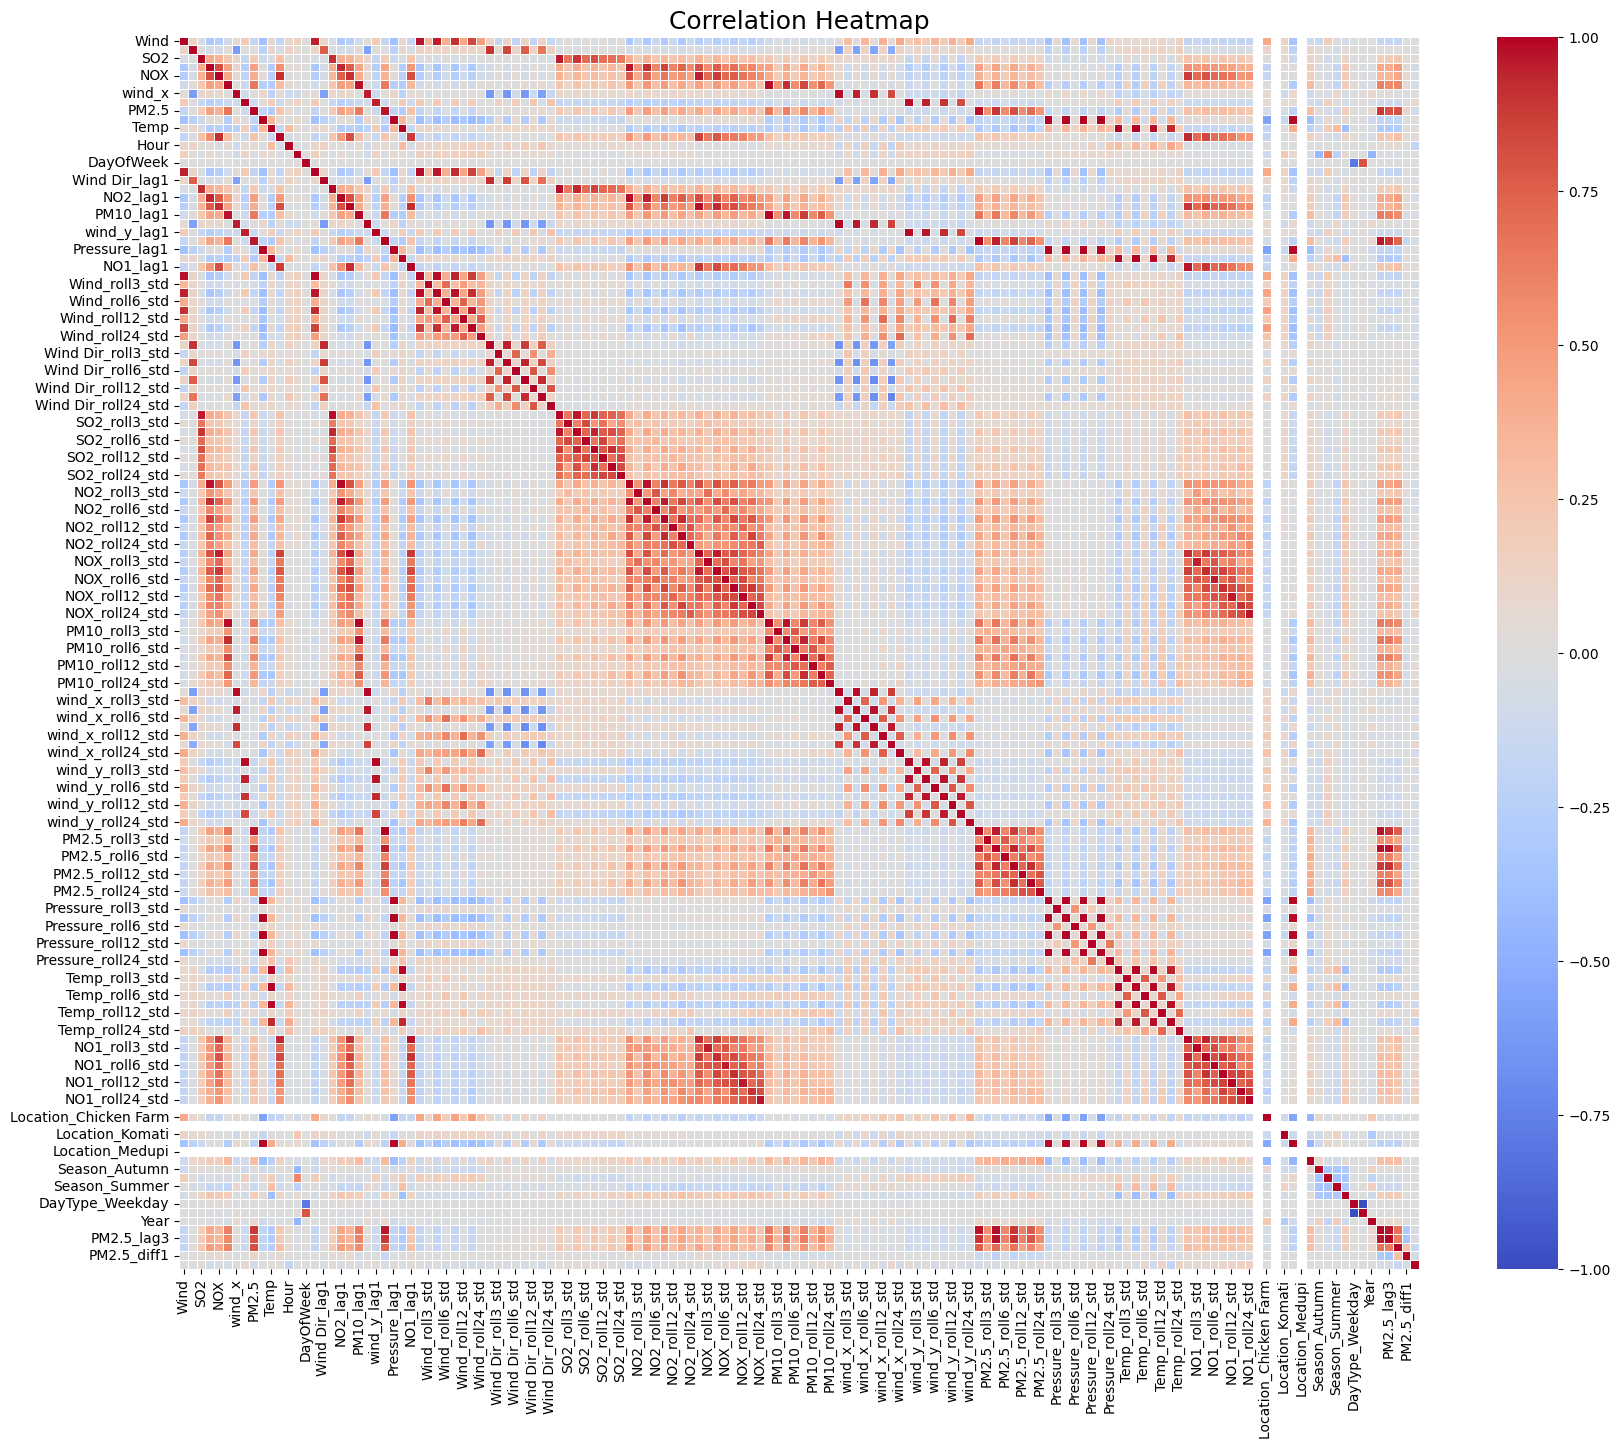

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = data_for_model.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))

# Generate a heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)

# Add title
plt.title('Correlation Heatmap', fontsize=18)
plt.show()


In [ ]:
# Compute correlations with the target
target = 'PM2.5_t+24'
correlations = data_for_model.corr()[target].drop(target)

# Sort by absolute correlation (strongest relationships first)
feature_ranking = correlations.abs().sort_values(ascending=False)

# Display top 15 features most correlated with PM2.5_t+12
print("Top correlated features with PM2.5_t+24:\n")
print(feature_ranking.head(20))

Top correlated features with PM2.5_t+3:

PM2.5                0.807164
PM2.5_roll3_mean     0.753901
PM2.5_lag1           0.732686
PM2.5_roll6_mean     0.717385
PM2.5_lag2           0.676874
PM2.5_roll12_mean    0.671656
PM2.5_lag3           0.638298
PM10                 0.600229
PM2.5_roll24_mean    0.595660
PM10_roll3_mean      0.573049
PM10_lag1            0.562343
PM10_roll6_mean      0.548071
PM10_roll12_mean     0.510598
NO2_roll3_mean       0.487806
NO2                  0.486029
NO2_lag1             0.476200
NO2_roll6_mean       0.473454
PM10_roll24_mean     0.454604
PM2.5_roll6_std      0.452913
PM2.5_roll12_std     0.448189
Name: PM2.5_t+3, dtype: float64


In [11]:
feature_ranking

PM2.5                 0.807164
PM2.5_roll3_mean      0.753901
PM2.5_lag1            0.732686
PM2.5_roll6_mean      0.717385
PM2.5_lag2            0.676874
                        ...   
wind_x_lag1           0.001795
wind_x_roll3_mean     0.001790
Location_Camden            NaN
Location_Grootvlei         NaN
Location_Medupi            NaN
Name: PM2.5_t+3, Length: 141, dtype: float64

In [12]:
data_for_model

,Wind,Wind Dir,SO2,NO2,NOX,PM10,wind_x,wind_y,PM2.5,Pressure,Temp,NO1,Hour,Month,DayOfWeek,Wind_lag1,Wind Dir_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,wind_x_lag1,wind_y_lag1,PM2.5_lag1,Pressure_lag1,Temp_lag1,NO1_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,Wind Dir_roll3_mean,Wind Dir_roll3_std,Wind Dir_roll6_mean,Wind Dir_roll6_std,Wind Dir_roll12_mean,Wind Dir_roll12_std,Wind Dir_roll24_mean,Wind Dir_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,wind_x_roll3_mean,wind_x_roll3_std,wind_x_roll6_mean,wind_x_roll6_std,wind_x_roll12_mean,wind_x_roll12_std,wind_x_roll24_mean,wind_x_roll24_std,wind_y_roll3_mean,wind_y_roll3_std,wind_y_roll6_mean,wind_y_roll6_std,wind_y_roll12_mean,wind_y_roll12_std,wind_y_roll24_mean,wind_y_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Temp_roll3_mean,Temp_roll3_std,Temp_roll6_mean,Temp_roll6_std,Temp_roll12_mean,Temp_roll12_std,Temp_roll24_mean,Temp_roll24_std,NO1_roll3_mean,NO1_roll3_std,NO1_roll6_mean,NO1_roll6_std,NO1_roll12_mean,NO1_roll12_std,NO1_roll24_mean,NO1_roll24_std,Location_Camden,Location_Chicken Farm,Location_Grootvlei,Location_Komati,Location_Marapong,Location_Medupi,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend,Year,PM2.5_lag2,PM2.5_lag3,PM2.5_t+3,PM2.5_diff1,Temp_diff1
0,7.156286,91.864860,13.810,1.324,10.920,146.10,7.152496,-0.232881,53.25,844.0,22.32,14.190,16.0,1.0,4.0,6.538234,94.814120,17.240,1.212,12.660,141.30,6.515168,-0.548711,51.60,843.0,22.84,15.760,6.545746,0.606818,6.248888,0.521865,5.386216,1.413779,3.545463,2.143104,96.116160,5.030330,100.225297,5.786552,88.152249,28.361182,146.442456,131.768226,17.203333,3.375149,21.300000,4.977252,21.278833,10.671948,13.049708,11.186610,1.234333,0.080848,1.241667,0.340487,1.187333,0.432131,1.375333,0.775626,13.756667,3.515712,16.935000,4.484880,17.952500,7.249993,15.574583,5.792939,139.366667,7.879932,137.300000,7.647222,137.300000,7.647222,137.300000,7.647222,6.495850,0.666515,6.128177,0.590215,5.041310,1.851542,2.433458,2.988820,-0.661201,0.494260,-1.070225,0.585140,-0.465186,1.502653,0.554899,1.508712,50.580000,3.300409,52.077500,4.028874,52.077500,4.028874,52.077500,4.028874,843.666667,0.57735,843.500000,0.547723,843.666667,0.492366,843.916667,0.503610,22.580000,0.260000,23.235000,0.966969,25.302500,2.711645,26.733333,2.422481,16.306667,2.436439,20.715000,5.399803,21.385833,7.870918,17.270000,6.932891,False,True,False,False,False,False,False,False,False,True,False,True,False,2016.0,46.89,56.57,43.650,1.65,-0.52
1,6.355300,99.274250,9.970,1.302,13.420,146.40,6.272225,-1.024222,51.61,844.0,21.94,15.790,16.0,1.0,4.0,7.156286,91.864860,13.810,1.324,10.920,146.10,7.152496,-0.232881,53.25,844.0,22.32,14.190,6.683273,0.419728,6.280493,0.521559,5.701327,1.121093,3.740211,2.178418,95.317743,3.730280,98.996705,4.858929,93.506458,22.972262,149.833313,129.341140,13.673333,3.636926,18.690000,6.206651,21.722583,10.007441,13.262250,11.072296,1.279333,0.059341,1.152000,0.188178,1.206083,0.431790,1.301500,0.686066,12.333333,1.281614,15.295000,3.369948,17.910000,7.277161,15.450833,5.806469,144.600000,2.861818,139.120000,7.773159,139.120000,7.773159,139.120000,7.773159,6.646630,0.454621,6.189000,0.5

## Feature Selection

In [ ]:
features = feature_ranking.head(20).index.tolist()

In [ ]:
X = pd.concat([df_train[features], df_test[features]])#data_for_model[features]
y = pd.concat([df_train['PM2.5_t+24'], df_test['PM2.5_t+24']])#data_for_model['PM2.5_t+3']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [15]:
y

0         43.650
1         35.660
2         30.970
3         27.040
4         32.590
           ...  
294737    24.660
294738    15.620
294739    12.350
294740     3.836
294741     0.195
Name: PM2.5_t+3, Length: 270501, dtype: float64

## Data splitting for models

In [ ]:
# Let's use 80% of the data for training, 20% for testing
#split_idx = int(len(X_scaled) * 0.8)

split_idx = int(len(X_scaled) * 0.6)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


## LSTM Model (Neural Network)

In [17]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
6763/6763 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 272.4103 - val_loss: 346.7280
Epoch 2/50
6763/6763 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 178.1386 - val_loss: 337.5648
Epoch 3/50
6763/6763 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 172.5549 - val_loss: 336.6933
Epoch 4/50
6763/6763 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 164.8691 - val_loss: 343.5251
Epoch 5/50
6763/6763 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 170.3748 - val_loss: 342.9508
Epoch 6/50
6763/6763 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 161.5399 - val_loss: 329.6411
Epoch 7/50
6763/6763 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 169.5226 - val_loss: 335.8384
Epoch 8/50
6763/6763 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 164.6344 - val_loss: 341.6228
Epoch 9/50
6763/6763 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 165.5730 - val_loss: 329.2344
Epoch 10/50
6763/6763 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 160.2110 - val_loss: 359.6781
Epoch 11/50
6763/6763 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 168.8

In [18]:
#Prediction accuracy
y_pred = model.predict(X_test).flatten()

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R²: {r2}")
print(f"RMSE: {rmse}")


1691/1691 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
R²: 0.7700756165689335
RMSE: 17.97768158717946


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
#Validation data prediction
X_val = df_val[features]
y_val = df_val['PM2.5_t+24']

X_val_scaled = scaler.fit_transform(X_val)


y_pred_val = model.predict(X_val_scaled)

r2 = r2_score(y_val, y_pred_val)
rmse = mean_squared_error(y_val, y_pred_val, squared=False)

print(f"R²: {r2}")
print(f"RMSE: {rmse}")

758/758 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
R²: 0.3535059768587313
RMSE: 15.851213212364788


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
last_known_data = data_for_model.iloc[-1][features].values.reshape(1, -1)
last_known_data_scaled = scaler.transform(last_known_data)

forecast_3hr = model.predict(last_known_data_scaled)[0][0]
print(f"Forecasted PM2.5 (24 hrs ahead): {forecast_3hr}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Forecasted PM2.5 (3 hrs ahead): 14.489206314086914


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


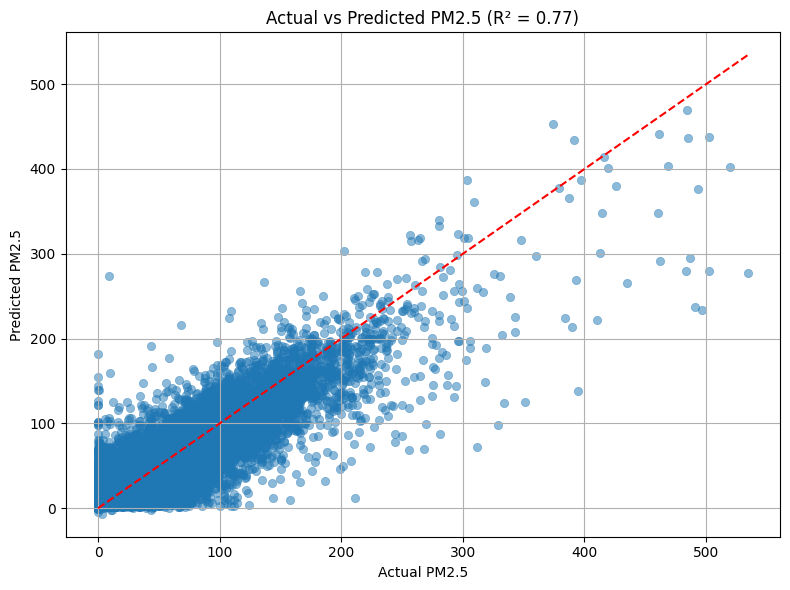

In [21]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title(f'Actual vs Predicted PM2.5 (R² = {r2_score(y_test, y_pred):.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
y_val

88910      6.033
88911      7.967
88912     12.030
88913     12.600
88914     13.200
           ...  
215480    20.230
215481    21.470
215482    25.360
215483    23.390
215484    24.910
Name: PM2.5_t+3, Length: 24241, dtype: float64

# Testing out XGBoost Regressor and Random Forrest Regressor

In [ ]:
X = pd.concat([df_train[features], df_test[features]])#data_for_model[features]
y = pd.concat([df_train['PM2.5_t+24'], df_test['PM2.5_t+24']])#data_for_model['PM2.5_t+3']

In [24]:
#Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
#Random Forrest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)


In [26]:
#XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)


## Model Evaluation

In [27]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Performance:")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))
    print("R2 Score:", r2_score(y_true, y_pred))

evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)



Random Forest Performance:
MAE: 8.51550782802536
RMSE: 14.391826728708278
R2 Score: 0.7581133842146844

XGBoost Performance:
MAE: 8.608830519480877
RMSE: 14.503549308240565
R2 Score: 0.7543433152024765


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0.5, 1.0, 'Random Forest: Actual vs Predicted')

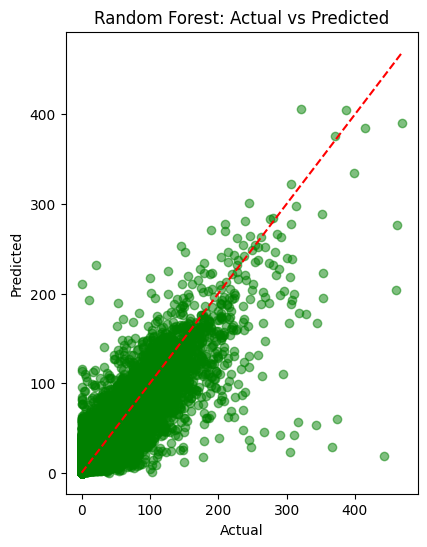

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_preds, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest: Actual vs Predicted")

Text(0.5, 1.0, 'XGBoost: Actual vs Predicted')

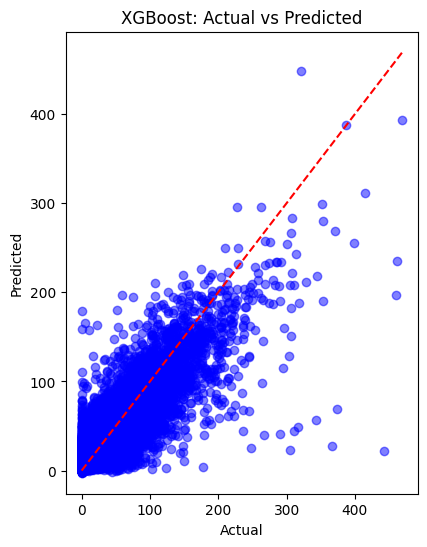

In [29]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 2)
plt.scatter(y_test, xgb_preds, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost: Actual vs Predicted")

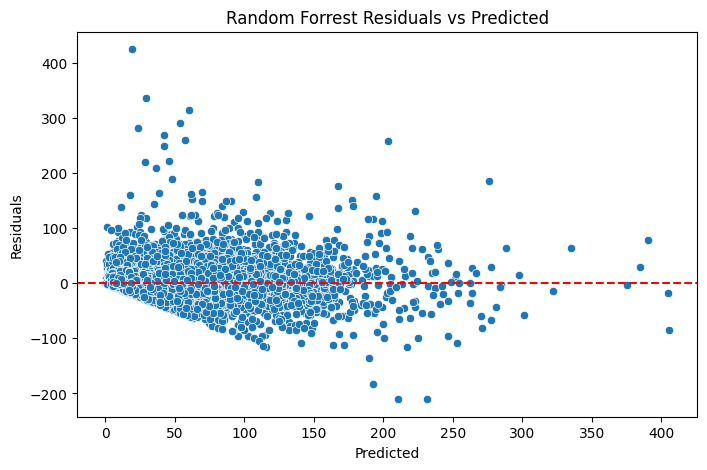

In [41]:
residuals = y_test - rf_preds

plt.figure(figsize=(8, 5))
sns.scatterplot(x=rf_preds, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Random Forrest Residuals vs Predicted")
plt.show()

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

mae = cross_val_score(model, X, y, cv=5, scoring=make_scorer(mean_absolute_error))

print(f"Cross-validated MAE: {mae.mean():.4f}")

TypeError: Cannot clone object '<Sequential name=sequential, built=True>' (type <class 'keras.src.models.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

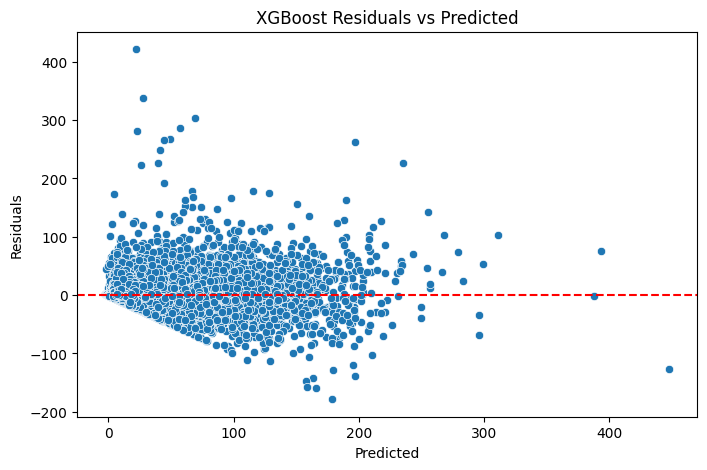

In [40]:
residuals = y_test - xgb_preds

plt.figure(figsize=(8, 5))
sns.scatterplot(x=xgb_preds, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("XGBoost Residuals vs Predicted")
plt.show()

In [32]:
#Validation performance

rf_val = rf.predict(X_val)

xgb_val = xgb.predict(X_val)

evaluate_model("Random Forrest", y_val, rf_val)
evaluate_model("XGBoost", y_val, xgb_val )


Random Forrest Performance:
MAE: 6.632486201311827
RMSE: 11.458059752499002
R2 Score: 0.6621984295296665

XGBoost Performance:
MAE: 6.594533221429209
RMSE: 11.620246317251487
R2 Score: 0.6525677195906788


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0.5, 1.0, 'Random Forest Validation: Actual vs Predicted')

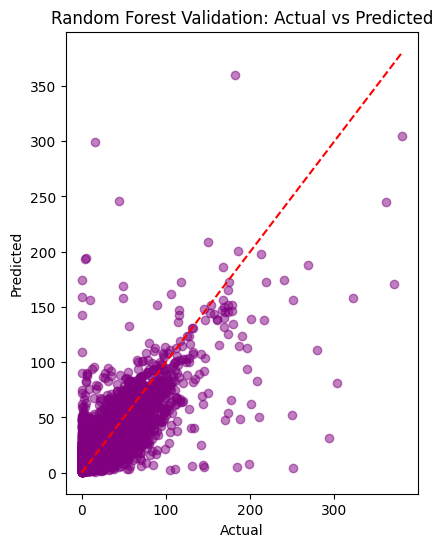

In [33]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.scatter(y_val, rf_val, alpha=0.5, color='purple')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest Validation: Actual vs Predicted")

Text(0.5, 1.0, 'XGBoost Validation: Actual vs Predicted')

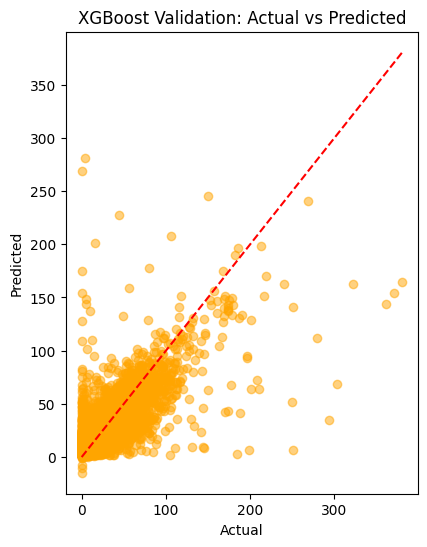

In [34]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.scatter(y_val, xgb_val, alpha=0.5, color='orange')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost Validation: Actual vs Predicted")

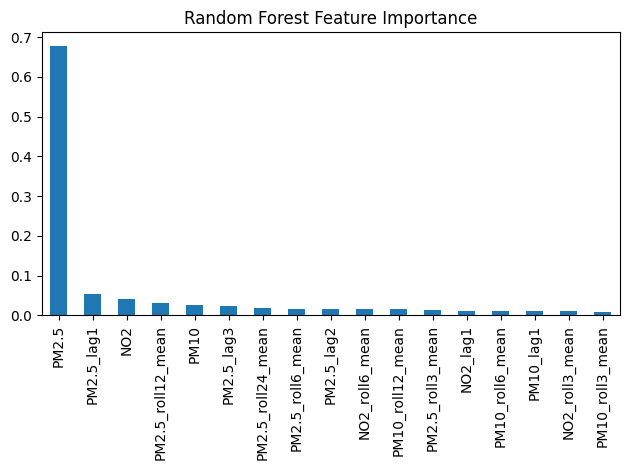

In [35]:
import matplotlib.pyplot as plt

# For Random Forest
rf_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
rf_importance.plot(kind='bar', title='Random Forest Feature Importance')
plt.tight_layout()
plt.show()




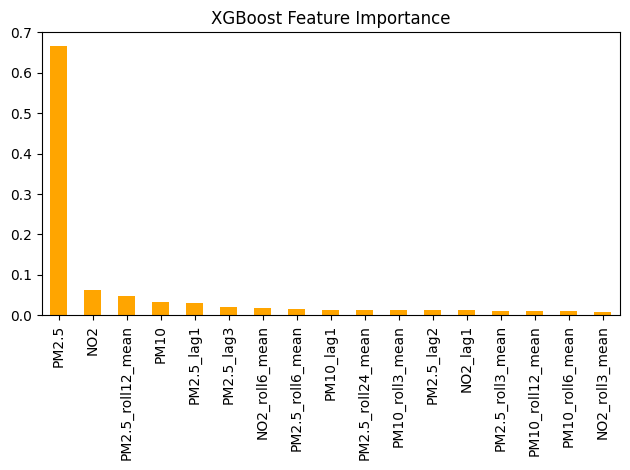

In [36]:
# For XGBoost
xgb_importance = pd.Series(xgb.feature_importances_, index=features).sort_values(ascending=False)
xgb_importance.plot(kind='bar', title='XGBoost Feature Importance', color='orange')
plt.tight_layout()
plt.show()

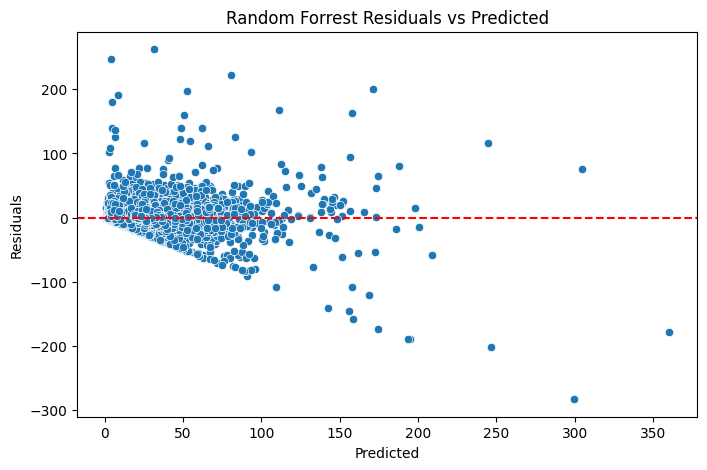

In [42]:
residuals = y_val - rf_val

plt.figure(figsize=(8, 5))
sns.scatterplot(x=rf_val, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Random Forrest Residuals vs Predicted")
plt.show()

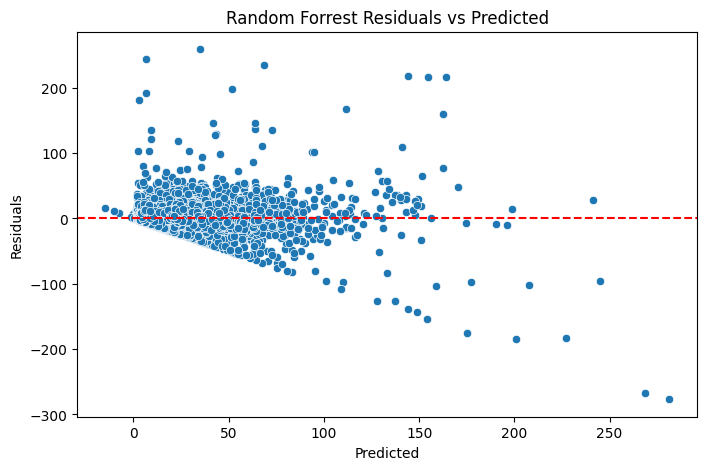

In [43]:
residuals = y_val - xgb_val

plt.figure(figsize=(8, 5))
sns.scatterplot(x=xgb_val, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Random Forrest Residuals vs Predicted")
plt.show()